In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('../bioAI.mplstyle')
import expipe
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

from scipy.interpolate import interp1d

sys.path.append('..')
import ca2_mec.project_path
import expipe_plugin_cinpla
import ca2_mec.dataloader as dl
import spatial_maps as sp
from ca2_mec.utils import cell_rate
from ca2_mec.plotting_functions import spike_track, axis_off_labels_on

In [6]:
project_path = ca2_mec.project_path.project_path()

project = expipe.get_project(project_path)
actions = project.actions

### Initialise data loader

In [9]:
lim = None#[0,1200] # limit recording times - in seconds
include_actions = ['001-181220-2', '001-181220-3', '001-181220-4', '001-181220-5', '001-181220-6']

# Cast assertion error if include_actions contain actions from multiple entities. 
animal_entity = include_actions[0].split('-')[0]
multiple_entities = all([animal_entity in action_id for action_id in include_actions])
assert multiple_entities, "Requires only actions from same animal entity! Read start of notebook!"

spikes = []
tracking = {}
for action_id in include_actions:
    spikes += dl.load_and_populate_spiketrains(action_id, lim=lim, identify_neurons=True)
    tracking[action_id] = dl.load_tracking(action_id, lim=lim, ca2_transform_data=True) # only get positions


print("load #spikes: ", len(spikes))

"""
# correct for inconsistent mua-annotations
spikes = dl.correct_mua(spikes, only_good_mua=True)
print("#units after mua-corrections:", len(spikes))
spatial_map = sp.SpatialMap()

# SELECT brain region(s) to include cells from
spikes = dl.in_brain_regions(spikes, ['ca2'])
print("#units after brain region selection:", len(spikes))

# only include cells that are persistent across all actions
spikes = dl.persistent_units(spikes, include_actions)
print(f"Num spike_trains: {len(spikes)}. Num persistent units: {len(spikes) / len(include_actions)}")
"""

spatial_map = sp.SpatialMap()

/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(
/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(
/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(
/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(
/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(
/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(


load #spikes:  61


In [10]:
spikes.sort(key=lambda sptr: sptr.annotations["mua_quality"],reverse=True)
spikes.sort(key=lambda sptr: sptr.annotations["action_id"])
spikes.sort(key=lambda sptr: sptr.annotations["unit_idnum"])
spikes.sort(key=lambda sptr: len(sptr.annotations["persistent_trials"]),reverse=True)
include_actions.sort()

"""
for sptr in spikes:
    print(sptr.annotations["action_id"], sptr.annotations["unit_idnum"], len(sptr.annotations["persistent_trials"]))
"""
_=2

In [11]:
unique_unsorted_unit_idnums = []
for sptr in spikes:
    if sptr.annotations["unit_idnum"] not in unique_unsorted_unit_idnums:
        unique_unsorted_unit_idnums.append(sptr.annotations["unit_idnum"])

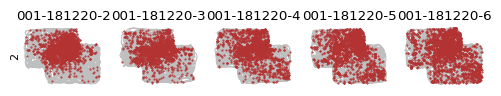

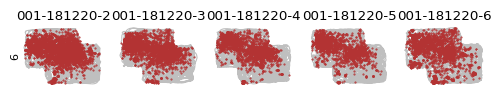

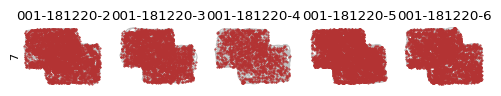

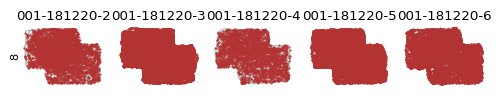

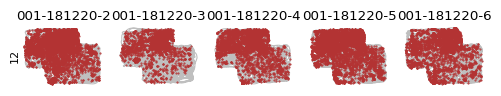

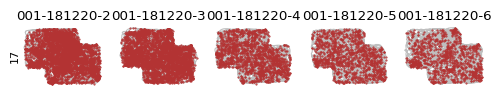

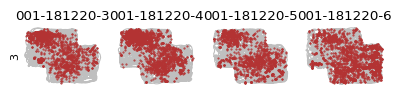

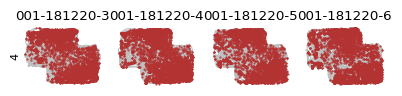

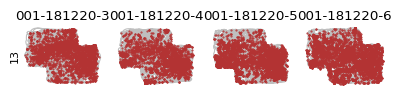

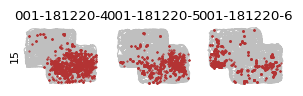

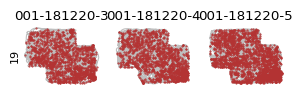

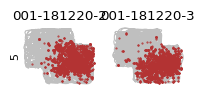

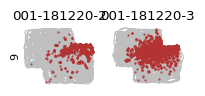

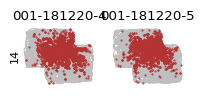

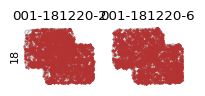

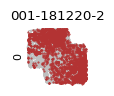

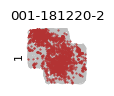

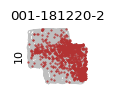

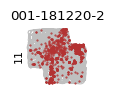

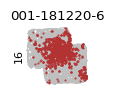

In [12]:
# sort on unit id
figscale = 1

add_title = True
for unit_idnum in unique_unsorted_unit_idnums:
    unit_spikes = [spike_train for spike_train in spikes if spike_train.annotations["unit_idnum"] == unit_idnum]
    fig,axs = plt.subplots(ncols=len(unit_spikes),figsize=(len(unit_spikes)*figscale, 1*figscale))
    axs = np.array([axs]) if type(axs) != np.ndarray else axs
    for ax, spike_train in zip(axs, unit_spikes):
        x,y,t,_ = tracking[spike_train.annotations["action_id"]].T
        ax = spike_track(x,y,t,spike_train,ax,spines=False)
        axis_off_labels_on(ax)
        
        # add action_id title to first few plots
        if add_title:
            ax.set_title(spike_train.annotations["action_id"])
    #add_title = False
    
    axs[0].set_ylabel(spike_train.annotations["unit_idnum"])

    #fig.savefig(f"./plots/spikes-and-track-{unit_idnum}")
    #plt.savefig('./plots/MECtrack'+str(unit_idnum)+'.pdf',dpi=300)